In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

plt.rcParams["figure.figsize"] = (10,10)

In [82]:
# Original dataframe
attrs = ["letter", "x-box", "y-box", "width", "high", "onpix", "x-bar",
         "y-bar", "x2bar", "y2bar", "xybar", "x2ybr", "xy2br", "x-ege",
         "xegvy", "y-ege", "yegvx"]
df = pd.read_csv("data/letter-recognition.data", names=attrs)
#letters = list(df["letter"])

# Represent letter with number
# A = 0, ...,  Z = 25
#df["letter"] = df["letter"].apply(lambda letter: ord(letter) - 65)

df.head()

,letter,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [83]:
# data split
X, Y = df.iloc[:, 1:], df.iloc[:, 0]
#X = StandardScaler().fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    train_size = 0.8, 
                                                    random_state = 8,
                                                    shuffle = True,
                                                    stratify = Y)

In [88]:
pca = PCA(n_components="mle").fit(X_train)
pca_result = pca.transform(X_train)
var_ratio = pca.explained_variance_ratio_
var_ratio

array([0.2863262 , 0.15025069, 0.12515027, 0.08703991, 0.07602276,
       0.05677524, 0.05050617, 0.03949068, 0.03166634, 0.02380185,
       0.01771176, 0.0160354 , 0.01506276, 0.01250641, 0.00799075])

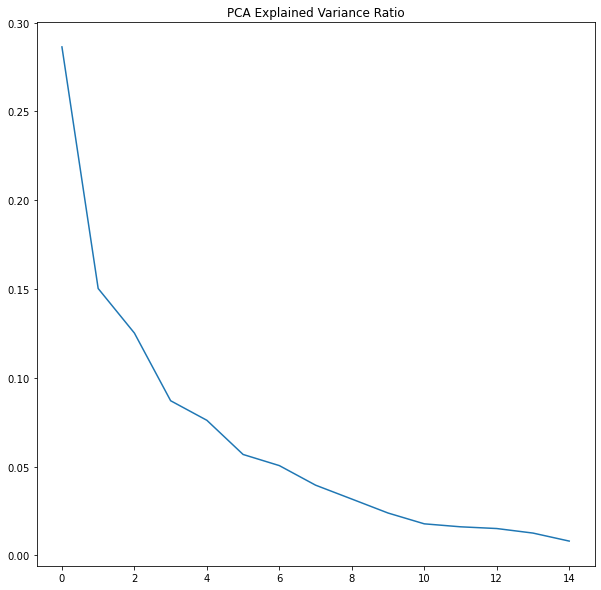

In [89]:
sns.lineplot(data=pca.explained_variance_ratio_)
plt.title("PCA Explained Variance Ratio")
plt.show()

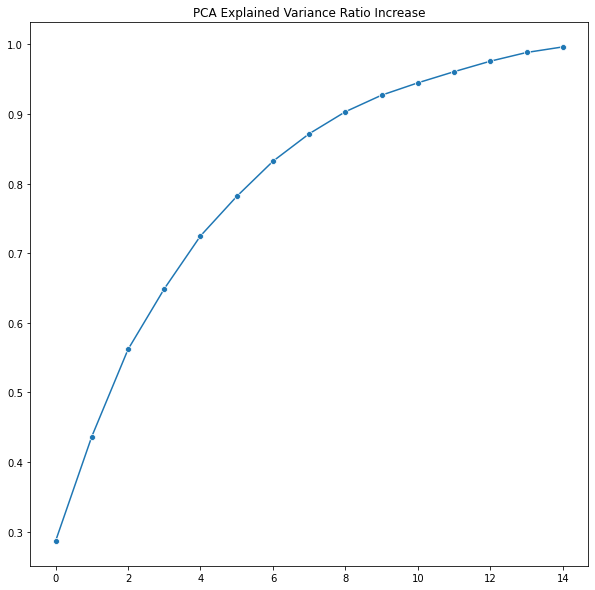

In [93]:
composite_ratio = [sum(var_ratio[:x+1]) for x in range(len(var_ratio))]
sns.lineplot(data=composite_ratio, marker="o")
plt.title("PCA Explained Variance Ratio Increase")
plt.show()

## 2 PC

In [53]:
pca_PC2 = PCA(n_components=2).fit_transform(X_train)
df_PC2 = pd.DataFrame(pca_PC2, columns=["PC1", "PC2"])
df_PC2["letter"] = list(Y_train)
df_PC2.head()

,PC1,PC2,letter
0,-0.648562,4.594162,Y
1,2.882913,4.688160,V
2,7.095410,0.337155,D
3,5.638809,-2.367114,O
4,-1.758309,-1.423537,H


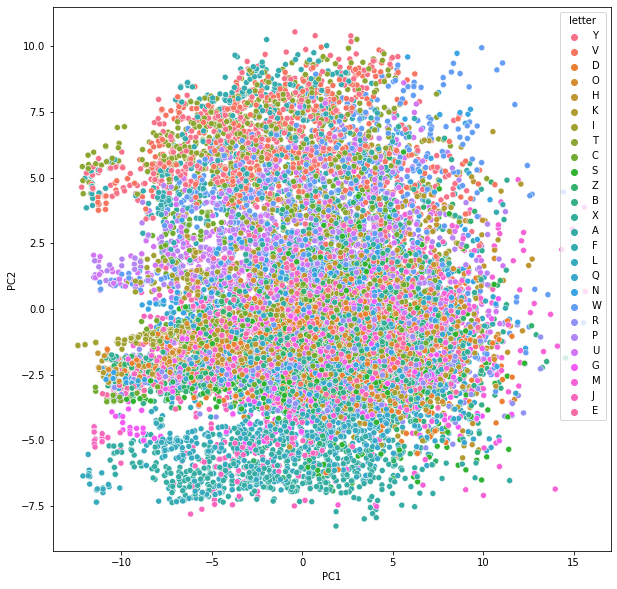

In [54]:
sns.scatterplot(x="PC1", y="PC2", hue="letter", data=df_PC2)
plt.show()

In [56]:
Ks = np.arange(1, 57, 2)

pipe = Pipeline([('knn', KNeighborsClassifier())])

search_space = [{'knn': [KNeighborsClassifier()],
                 'knn__weights': ['uniform', 'distance'],
                 'knn__n_neighbors': Ks}
                ]

search = GridSearchCV(pipe,
                      search_space,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      refit=False,
                      cv = StratifiedKFold(n_splits=5),
                      verbose = 3)

In [58]:
%%time
best_knn = search.fit(df_PC2[["PC1", "PC2"]], df_PC2["letter"])

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.1s


Wall time: 6.75 s


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    6.6s finished


In [62]:
best_knn.cv_results_['params'][np.argmin(best_knn.cv_results_['rank_test_score'])]

{'knn': KNeighborsClassifier(),
 'knn__n_neighbors': 55,
 'knn__weights': 'distance'}

In [66]:
knn = KNeighborsClassifier(weights = best_knn.cv_results_['params'][np.argmin(best_knn.cv_results_['rank_test_score'])].get('knn__weights'),
                           n_neighbors = best_knn.cv_results_['params'][np.argmin(best_knn.cv_results_['rank_test_score'])].get('knn__n_neighbors')
                              )
    
knn.fit(df_PC2[["PC1", "PC2"]], df_PC2["letter"])
    
train_acc = accuracy_score(df_PC2["letter"], knn.predict(df_PC2[["PC1", "PC2"]]))

train_acc

1.0

In [68]:
pca_PC2_test = PCA(n_components=2).fit_transform(X_test)
test_acc = accuracy_score(Y_test, knn.predict(pca_PC2_test))
test_acc

0.18725

## 8PC

In [94]:
pca_PC8 = PCA(n_components=8).fit_transform(X_train)
df_PC8 = pd.DataFrame(pca_PC8)
df_PC8["letter"] = list(Y_train)
df_PC8.head()

,0,1,2,3,4,5,6,7,letter
0,-0.648566,4.594101,-4.087098,0.764531,-1.789339,0.631816,2.532505,-1.225501,Y
1,2.882937,4.687732,2.028799,-0.826182,0.430882,1.970364,1.214135,1.942053,V
2,7.095434,0.336821,-0.495208,0.839825,0.238656,1.237006,2.092719,-0.981432,D
3,5.638769,-2.366649,-1.425487,-0.999650,-0.187809,-0.235515,0.869938,-1.445313,O
4,-1.758332,-1.423273,1.119919,0.236873,-0.560181,-0.062173,0.209906,-1.544393,H


In [95]:
Ks = np.arange(1, 57, 2)

pipe = Pipeline([('knn', KNeighborsClassifier())])

search_space = [{'knn': [KNeighborsClassifier()],
                 'knn__weights': ['uniform', 'distance'],
                 'knn__n_neighbors': Ks}
                ]

search = GridSearchCV(pipe,
                      search_space,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      refit=False,
                      cv = StratifiedKFold(n_splits=5),
                      verbose = 3)

In [96]:
%%time
best_knn = search.fit(df_PC8.drop("letter", axis=1), df_PC8["letter"])

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    6.4s


Wall time: 15.4 s


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   15.3s finished


In [97]:
best_knn.cv_results_['params'][np.argmin(best_knn.cv_results_['rank_test_score'])]

{'knn': KNeighborsClassifier(),
 'knn__n_neighbors': 5,
 'knn__weights': 'distance'}

In [98]:
knn = KNeighborsClassifier(weights = best_knn.cv_results_['params'][np.argmin(best_knn.cv_results_['rank_test_score'])].get('knn__weights'),
                           n_neighbors = best_knn.cv_results_['params'][np.argmin(best_knn.cv_results_['rank_test_score'])].get('knn__n_neighbors'))
    
knn.fit(df_PC8.drop("letter", axis=1), df_PC8["letter"])
train_acc = accuracy_score(df_PC8["letter"], knn.predict(df_PC8.drop("letter", axis=1)))

pca_PC8_test = PCA(n_components=8).fit_transform(X_test)
test_acc = accuracy_score(Y_test, knn.predict(pca_PC8_test))

train_acc, test_acc

(1.0, 0.88475)

## Individual Parameter Correlation

In [5]:
corr_mtx = df.corr()

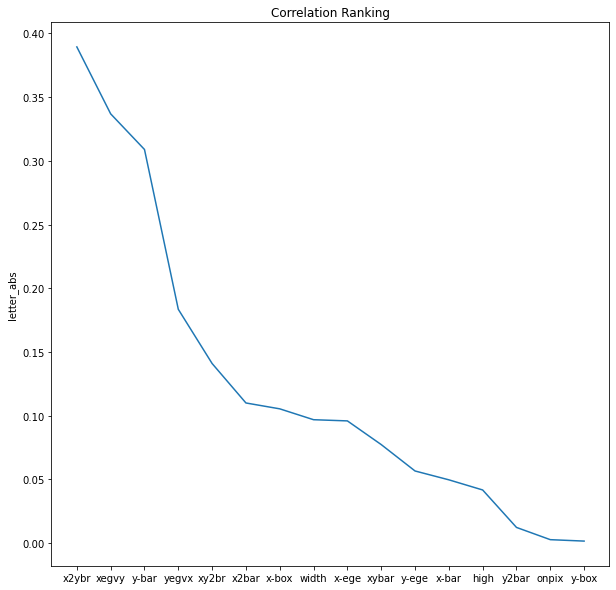

In [6]:
corr_mtx["letter_abs"] = corr_mtx["letter"].apply(lambda x: abs(x))
corr_rank = corr_mtx["letter_abs"].sort_values(ascending=False)
corr_rank = corr_rank.drop("letter")

sns.lineplot(data=corr_rank)
plt.title("Correlation Ranking")
plt.show()

In [ ]:
pca = PCA(n_components="mle").fit(df_pred)
pca.explained_variance_ratio_